## PREPROCESSING + MODELISATION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel("maladie_cardiovasculaire.xlsx")

In [3]:
df = data.copy()
df.head()

,AGE,SEXE,TDT,PAR,CHOLESTEROL,GAJ,ECG,FCMAX,ANGINE,DEPRESSION,PENTE,CŒUR
0,40,homme,AA,140,289,0,Normal,172,Non,0.0,Ascendant,0
1,49,femme,DNA,160,180,0,Normal,156,Non,1.0,Plat,1
2,37,homme,AA,130,283,0,ST,98,Non,0.0,Ascendant,0
3,48,femme,ASY,138,214,0,Normal,108,Oui,1.5,Plat,1
4,54,homme,DNA,150,195,0,Normal,122,Non,0.0,Ascendant,0


In [4]:
df.rename(columns={'DEPRESSION ':'DEPRESSION'}, inplace=True)
df['DEPRESSION'].head()

0    0.0
1    1.0
2    0.0
3    1.5
4    0.0
Name: DEPRESSION, dtype: float64

In [5]:
df.isna().sum()

AGE            0
SEXE           0
TDT            0
PAR            0
CHOLESTEROL    0
GAJ            0
ECG            0
FCMAX          0
ANGINE         0
DEPRESSION     0
PENTE          0
CŒUR           0
dtype: int64

In [6]:
df.duplicated().sum()

0

### ENCODAGE FEATURE QUALITATIVE

In [7]:
df_quali = df.select_dtypes("object")
variables_quali = df_quali.columns
df_quali.head()

,SEXE,TDT,ECG,ANGINE,PENTE
0,homme,AA,Normal,Non,Ascendant
1,femme,DNA,Normal,Non,Plat
2,homme,AA,ST,Non,Ascendant
3,femme,ASY,Normal,Oui,Plat
4,homme,DNA,Normal,Non,Ascendant


In [8]:
### Fonction d'encodage OneHot
def encodage_OneHotEncoder(df_quali):
    
    encode = OneHotEncoder(sparse=False, drop='if_binary')
    
    df_quali_enc = pd.DataFrame(encode.fit_transform(df_quali), index=df_quali.index)
    df_quali_enc.columns = encode.get_feature_names(variables_quali)
    
    return df_quali_enc

In [9]:
df_quali = encodage_OneHotEncoder(df_quali)
df_quali.head()

,SEXE_homme,TDT_AA,TDT_ASY,TDT_AT,TDT_DNA,ECG_LVH,ECG_Normal,ECG_ST,ANGINE_Oui,PENTE_Ascendant,PENTE_Descendant,PENTE_Plat
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### CONCATENATION

In [10]:
df_new = pd.concat([df.select_dtypes(include=np.number), df_quali], axis=1)
df_new.head()

,AGE,PAR,CHOLESTEROL,GAJ,FCMAX,DEPRESSION,CŒUR,SEXE_homme,TDT_AA,TDT_ASY,TDT_AT,TDT_DNA,ECG_LVH,ECG_Normal,ECG_ST,ANGINE_Oui,PENTE_Ascendant,PENTE_Descendant,PENTE_Plat
0,40,140,289,0,172,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,49,160,180,0,156,1.0,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,37,130,283,0,98,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,48,138,214,0,108,1.5,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,54,150,195,0,122,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### SUBDIVISION DATASET

In [11]:
# Fonction pour diviser mon dataset en variables indépendantes et variables dépendantes
def decoupe_df(df):

    X=df.drop('CŒUR', axis=1)
    y=df['CŒUR']
    
    return X, y

In [12]:
X, y = decoupe_df(df_new)

print(df_new.shape)
print(X.shape)
print(y.shape)

(918, 19)
(918, 18)
(918,)


In [13]:
X_train, X_test ,y_train ,y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [14]:
X_train.head()

,AGE,PAR,CHOLESTEROL,GAJ,FCMAX,DEPRESSION,SEXE_homme,TDT_AA,TDT_ASY,TDT_AT,TDT_DNA,ECG_LVH,ECG_Normal,ECG_ST,ANGINE_Oui,PENTE_Ascendant,PENTE_Descendant,PENTE_Plat
132,56,170,388,0,122,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
9,48,120,284,0,120,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
254,55,145,248,0,96,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
787,67,100,299,0,125,0.9,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
82,63,150,223,0,115,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [15]:
y_train.head()

132    1
9      0
254    1
787    1
82     1
Name: CŒUR, dtype: int64

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(642, 18)
(276, 18)
(642,)
(276,)


### NORMALISATION FEATURES QUANTITATIVES CONTINUES

In [17]:
df.select_dtypes(include=np.number)

,AGE,PAR,CHOLESTEROL,GAJ,FCMAX,DEPRESSION,CŒUR
0,40,140,289,0,172,0.0,0
1,49,160,180,0,156,1.0,1
2,37,130,283,0,98,0.0,0
3,48,138,214,0,108,1.5,1
4,54,150,195,0,122,0.0,0
...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1
914,68,144,193,1,141,3.4,1
915,57,130,131,0,115,1.2,1
916,57,130,236,0,174,0.0,1


In [18]:
var_quant_cont = df.select_dtypes(include=np.number).drop(['GAJ','CŒUR'], axis=1).columns
var_quant_cont

Index(['AGE', 'PAR', 'CHOLESTEROL', 'FCMAX', 'DEPRESSION'], dtype='object')

In [19]:
### Créons une fonction et séparons les données quanti, des données quali chez les features X_train et X_test
def decoupe_X(X):

    X_quanti = X[var_quant_cont]
    X_quali = X.drop(columns=var_quant_cont)
    
    return X_quanti, X_quali

In [20]:
## Separation quanti quali X_train
X_train_quanti, X_train_quali = decoupe_X(X_train)

In [21]:
X_test_quanti, X_test_quali = decoupe_X(X_test)

In [22]:
X_train_quanti.head()

,AGE,PAR,CHOLESTEROL,FCMAX,DEPRESSION
132,56,170,388,122,2.0
9,48,120,284,120,0.0
254,55,145,248,96,2.0
787,67,100,299,125,0.9
82,63,150,223,115,0.0


In [23]:
X_train_quali.head()

,GAJ,SEXE_homme,TDT_AA,TDT_ASY,TDT_AT,TDT_DNA,ECG_LVH,ECG_Normal,ECG_ST,ANGINE_Oui,PENTE_Ascendant,PENTE_Descendant,PENTE_Plat
132,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
9,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
254,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
787,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
82,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [24]:
X_test_quanti.head()

,AGE,PAR,CHOLESTEROL,FCMAX,DEPRESSION
349,36,110,0,125,1.0
653,42,130,180,150,0.0
7,54,110,208,142,0.0
571,69,140,110,109,1.5
171,40,140,235,188,0.0


In [25]:
X_test_quali.head()

,GAJ,SEXE_homme,TDT_AA,TDT_ASY,TDT_AT,TDT_DNA,ECG_LVH,ECG_Normal,ECG_ST,ANGINE_Oui,PENTE_Ascendant,PENTE_Descendant,PENTE_Plat
349,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
653,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
571,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
171,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### NORMALISATION

Ensuite, créons une pipeline pour normaliser les variables quantitatives. Nous nous servons de la normalisation effectuer sur les données d'entrainement pour affecter les données de test.

In [26]:
## Pipeline pour normaliser X_train et X_test
def pipeline_normalizer(train,test):
    
    scaler = RobustScaler()

    df_train=scaler.fit_transform(train)
    df_train = pd.DataFrame(df_train, index=train.index, columns=train.columns)

    df_test = scaler.transform(test)
    df_test = pd.DataFrame(df_test, index=test.index, columns=test.columns)

    
    return df_train,df_test

In [27]:
X_train_quanti, X_test_quanti = pipeline_normalizer(X_train_quanti, X_test_quanti)

In [28]:
X_train_quanti.head()

,AGE,PAR,CHOLESTEROL,FCMAX,DEPRESSION
132,0.142857,2.00,1.733681,-0.432432,0.933333
9,-0.428571,-0.50,0.647520,-0.486486,-0.400000
254,0.071429,0.75,0.271540,-1.135135,0.933333
787,0.928571,-1.50,0.804178,-0.351351,0.200000
82,0.642857,1.00,0.010444,-0.621622,-0.400000


In [29]:
X_test_quanti.head()

,AGE,PAR,CHOLESTEROL,FCMAX,DEPRESSION
349,-1.285714,-1.0,-2.318538,-0.351351,0.266667
653,-0.857143,0.0,-0.438642,0.324324,-0.400000
7,0.000000,-1.0,-0.146214,0.108108,-0.400000
571,1.071429,0.5,-1.169713,-0.783784,0.600000
171,-1.000000,0.5,0.135770,1.351351,-0.400000


In [30]:
### RECONSTITUTION DES FEATURES
X_train = pd.concat([X_train_quanti, X_train_quali], axis=1)
X_test = pd.concat([X_test_quanti, X_test_quali], axis=1)

In [31]:
X_train.head()

,AGE,PAR,CHOLESTEROL,FCMAX,DEPRESSION,GAJ,SEXE_homme,TDT_AA,TDT_ASY,TDT_AT,TDT_DNA,ECG_LVH,ECG_Normal,ECG_ST,ANGINE_Oui,PENTE_Ascendant,PENTE_Descendant,PENTE_Plat
132,0.142857,2.00,1.733681,-0.432432,0.933333,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
9,-0.428571,-0.50,0.647520,-0.486486,-0.400000,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
254,0.071429,0.75,0.271540,-1.135135,0.933333,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
787,0.928571,-1.50,0.804178,-0.351351,0.200000,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
82,0.642857,1.00,0.010444,-0.621622,-0.400000,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [32]:
X_test.head()

,AGE,PAR,CHOLESTEROL,FCMAX,DEPRESSION,GAJ,SEXE_homme,TDT_AA,TDT_ASY,TDT_AT,TDT_DNA,ECG_LVH,ECG_Normal,ECG_ST,ANGINE_Oui,PENTE_Ascendant,PENTE_Descendant,PENTE_Plat
349,-1.285714,-1.0,-2.318538,-0.351351,0.266667,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
653,-0.857143,0.0,-0.438642,0.324324,-0.400000,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,0.000000,-1.0,-0.146214,0.108108,-0.400000,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
571,1.071429,0.5,-1.169713,-0.783784,0.600000,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
171,-1.000000,0.5,0.135770,1.351351,-0.400000,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### MODELISATION

In [33]:
# Les différents estimateurs
model_1 = KNeighborsClassifier()
model_2 = SVC(kernel='linear')
model_3 = LogisticRegression(solver='liblinear', random_state=0)
model_4 = RandomForestClassifier(random_state=0)

In [34]:
# Courbe d'apprentissage
plt.figure(figsize=(15,8))
def courbe_apprentissage(model,X_train, y_train):
    N, train_score, val_score = learning_curve(model, X_train, y_train,train_sizes=np.linspace(0.1,1.0,10), cv=5)
    plt.figure(figsize=(15,8))
    plt.plot(N, train_score.mean(axis=1), label='train')
    plt.plot(N, val_score.mean(axis=1), label='validation')
    plt.xlabel('train_size')
    plt.legend()
    plt.show()

<Figure size 1080x576 with 0 Axes>

KNeighborsClassifier
Score à l'entrainement : 0.9003115264797508
Score au test : 0.8731884057971014
[[ 97  23]
 [ 12 144]]
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       120
           1       0.86      0.92      0.89       156

    accuracy                           0.87       276
   macro avg       0.88      0.87      0.87       276
weighted avg       0.87      0.87      0.87       276



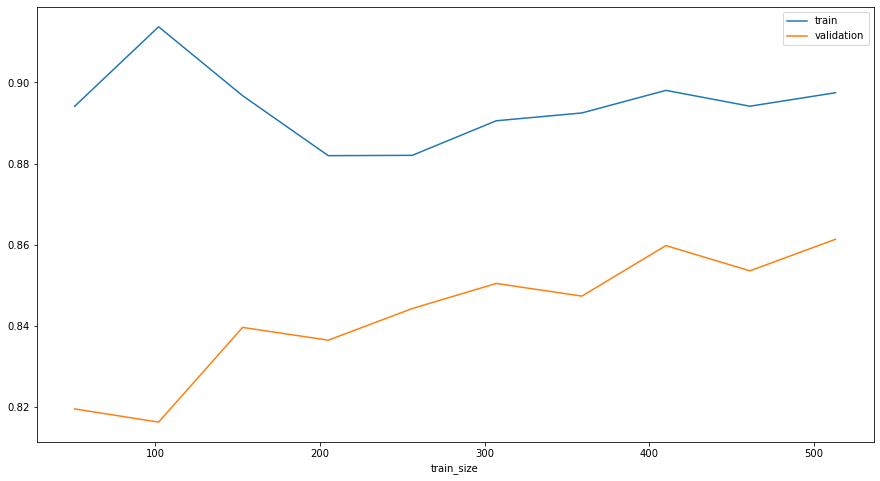

SVC
Score à l'entrainement : 0.8753894080996885
Score au test : 0.8586956521739131
[[ 97  23]
 [ 16 140]]
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       120
           1       0.86      0.90      0.88       156

    accuracy                           0.86       276
   macro avg       0.86      0.85      0.86       276
weighted avg       0.86      0.86      0.86       276



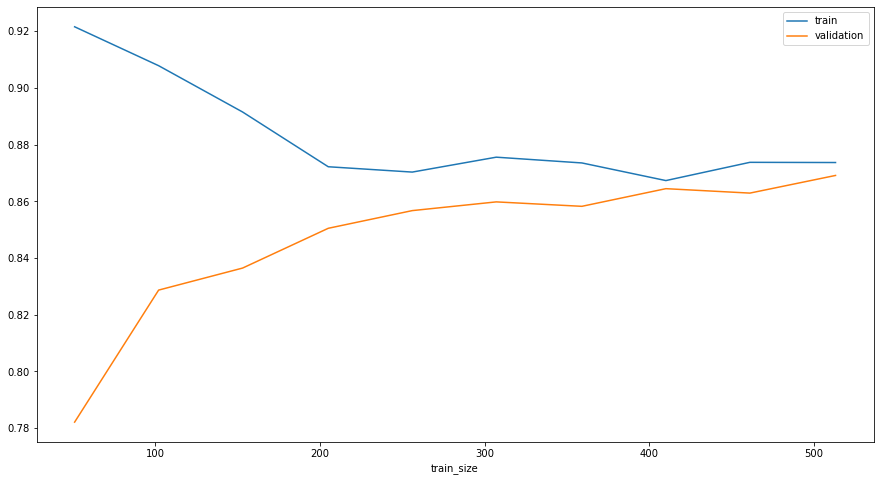

LogisticRegression
Score à l'entrainement : 0.8660436137071651
Score au test : 0.8659420289855072
[[ 97  23]
 [ 14 142]]
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       120
           1       0.86      0.91      0.88       156

    accuracy                           0.87       276
   macro avg       0.87      0.86      0.86       276
weighted avg       0.87      0.87      0.87       276



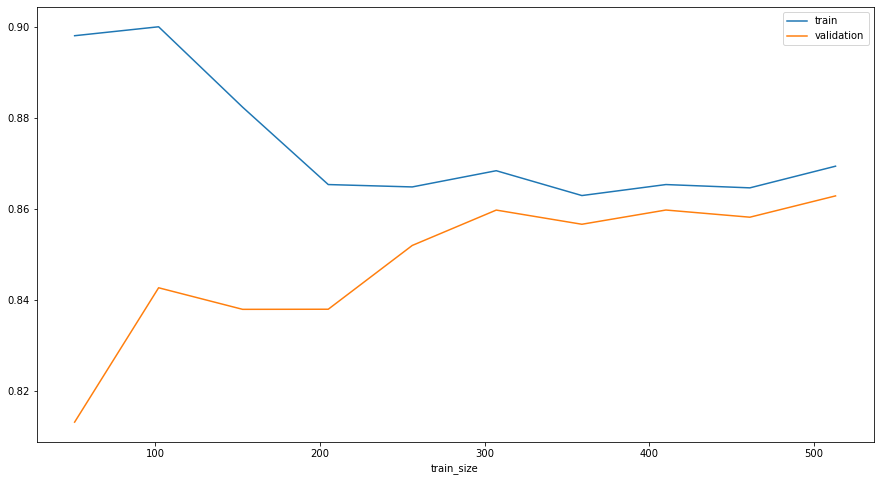

RandomForestClassifier
Score à l'entrainement : 1.0
Score au test : 0.8731884057971014
[[ 95  25]
 [ 10 146]]
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       120
           1       0.85      0.94      0.89       156

    accuracy                           0.87       276
   macro avg       0.88      0.86      0.87       276
weighted avg       0.88      0.87      0.87       276



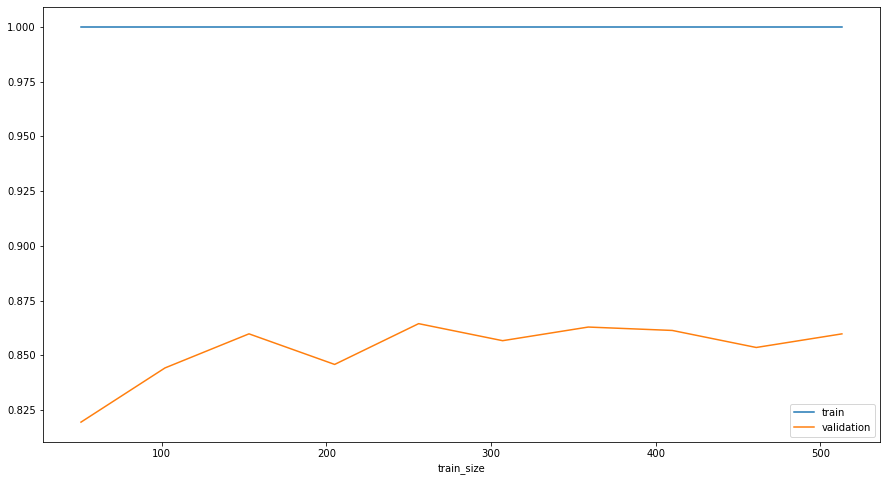

In [35]:
# entrainement de chaque modèle et performance de chaque modèle
for model in (model_1, model_2,  model_3, model_4):
    model.fit(X_train, y_train)
    print(model.__class__.__name__)
    print(f"Score à l'entrainement : {model.score(X_train, y_train)}")
    print(f"Score au test : {model.score(X_test, y_test)}")
    
    y_pred=model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test,y_pred))
    courbe_apprentissage(model, X_train, y_train)
    print(120*'=')

- L'objectif du projet est de prédire la présence ou l'absence de maladie cardiaque chez les patients de notre jeu de données afin de les fournir un traitement adéquat. 

- Il nous faut donc minimiser les faux négatifs (FN), les patients qui présentent des maladies cardiaques et que le modèle à prédire qu'elles sont saine. 

- La métrique à observé le plus ici est la sensibilité.

-----------------------------------------------------------------------------------------------------------------------

- Classement des modèles par rapport aux scores et à la sensibilté :
   - RandomForestClassifier : Score à l'entrainemment : 100%; Score test : 87.31%; Sensibilité = 94%.
   - Modèle Régression logistique : score test et entrainement d'environ 87%; Sensibilité = 91%.
   - Modèle KNN : score test : 87.31%, entrainement: 90%; Sensibilité = 92%.
   - SVC : score test : 86% , entrainement d'environ 87%; Sensibilité = 90%.
   
- Pour cette première modélisation, l'estimateur RandomForestClassifier obtient une sensibilité plus élevée mais semble etre en surapprentissage.

- L'estimateur qui le suit dans le classement est KNN qui obtient une meilleur sensibilité que les autres, de plus, en visualisant la courbe d'apprentissage, nous pouvons estimer que le modèle est stable.

- Essayons de faire une sélection de variables avec le modèle KNN et le modèle de régression logistique en vue d'améliorer nos scores.

### FEATURE SELECTION

In [36]:
def evaluation(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    print(model.__class__.__name__)
    print(f"Score à l'entrainement : {model.score(X_train, y_train)}")
    print(f"Score au test : {model.score(X_test, y_test)}")
    y_pred=model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test,y_pred))
    courbe_apprentissage(model, X_train, y_train)

In [43]:
def feature_selection(model, X_train, X_test):
    
    ## UTILISATION DE LA SELECTION DE FEATURES DE FACON RECURSIVE
    selector = RFECV(model, step=1, min_features_to_select=1, cv=5)
    selector.fit(X_train, y_train)
    
    ## Affichage des rangs et des scores
    print("Rang des variables : ")
    print(selector.ranking_)
    print("")
    
    print("Scores du model : ")
    print(selector.grid_scores_)
    print("")
    
    ## SELECTION DE COLONNES
    colonne_selectioner = np.array(X_train.columns)[selector.get_support()]
    print("Les colonnes sélectionnées : ")
    print(colonne_selectioner)
    print("")
    
    ## RECONSTITUTION DE MON DATASET AVEC LES COLONNES SELECTIONNEES
    X_train_review, X_test_review = X_train[colonne_selectioner], X_test[colonne_selectioner]
    
    return X_train_review, X_test_review

Rang des variables : 
[ 7 11  1 10  1  1  1  3  1  4  2  9  8  5  1  1  6  1]

Scores du model : 
[0.81157946 0.80532946 0.80064196 0.81929506 0.84731105 0.85356105
 0.83793605 0.87068798 0.86602471 0.8675751  0.8691376  0.86600048
 0.86912548 0.8675751  0.86912548 0.86912548 0.87068798 0.87068798]

Les colonnes sélectionnées : 
['CHOLESTEROL' 'DEPRESSION' 'GAJ' 'SEXE_homme' 'TDT_ASY' 'ANGINE_Oui'
 'PENTE_Ascendant' 'PENTE_Plat']

SVC
Score à l'entrainement : 0.867601246105919
Score au test : 0.8623188405797102
[[ 98  22]
 [ 16 140]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       120
           1       0.86      0.90      0.88       156

    accuracy                           0.86       276
   macro avg       0.86      0.86      0.86       276
weighted avg       0.86      0.86      0.86       276



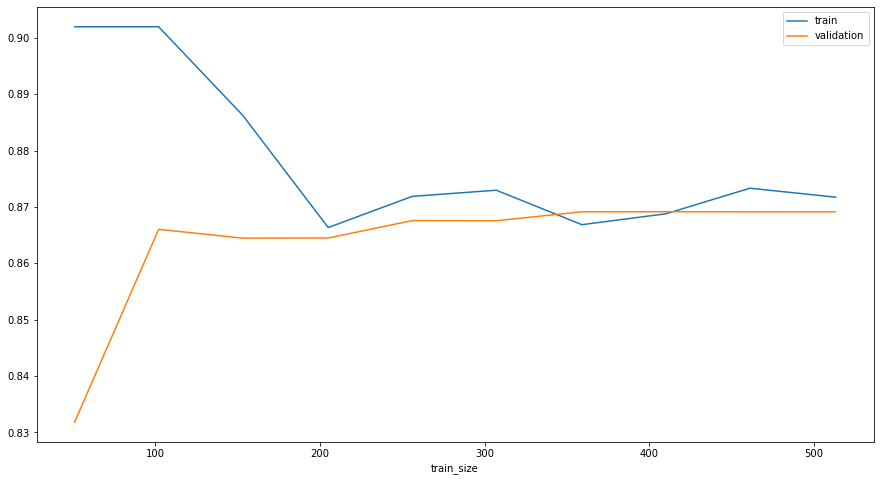

Rang des variables : 
[1 4 1 1 1 1 1 1 1 1 1 3 2 1 1 1 1 1]

Scores du model : 
[0.81157946 0.81157946 0.81618217 0.84419816 0.85972626 0.85818798
 0.85662548 0.85661337 0.84887355 0.85506298 0.8566376  0.8628876
 0.86443798 0.86600048 0.86756298 0.86755087 0.86600048 0.86287548]

Les colonnes sélectionnées : 
['AGE' 'CHOLESTEROL' 'FCMAX' 'DEPRESSION' 'GAJ' 'SEXE_homme' 'TDT_AA'
 'TDT_ASY' 'TDT_AT' 'TDT_DNA' 'ECG_ST' 'ANGINE_Oui' 'PENTE_Ascendant'
 'PENTE_Descendant' 'PENTE_Plat']

LogisticRegression
Score à l'entrainement : 0.8644859813084113
Score au test : 0.8623188405797102
[[ 97  23]
 [ 15 141]]
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       120
           1       0.86      0.90      0.88       156

    accuracy                           0.86       276
   macro avg       0.86      0.86      0.86       276
weighted avg       0.86      0.86      0.86       276



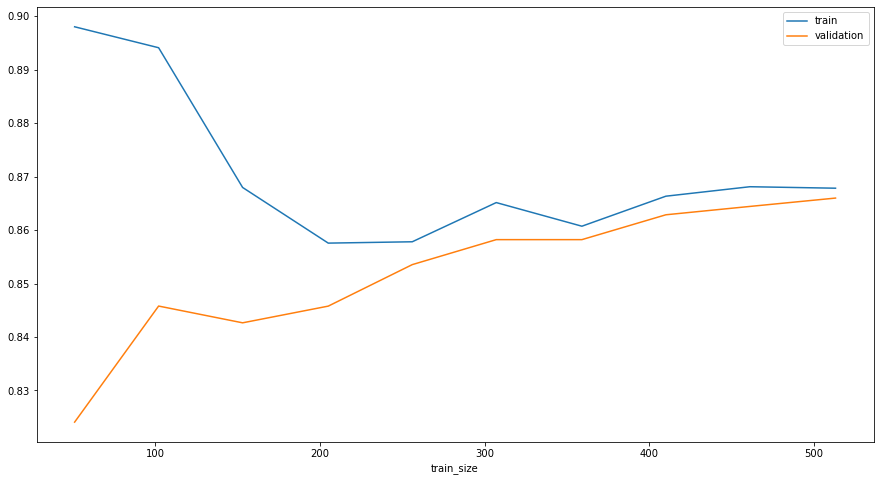

In [44]:
for model in (model_2, model_3):
    X_train_review, X_test_review = feature_selection(model, X_train, X_test)
    evaluation(model, X_train_review, y_train, X_test_review, y_test)

- J'ai essayé à cette partie de faire de la FEATURESELECTION sur le modèle qui présente le plus d'efficacité, mais cela n'a pas marché. Selon le site : https://stackoverflow.com/questions/37780139/knn-with-rfecv-returns-the-classifier-does-not-expose-coef-or-feature-impo, "knn ne fournit pas de logique pour faire la sélection des fonctionnalités. Vous ne pouvez pas l’utiliser (l’implémentation de sklearn) pour atteindre cet objectif, sauf si vous définissez votre propre mesure de l’importance des fonctionnalités pour KNN". Selon une autre source (https://mrmint.fr/introduction-k-nearest-neighbors), "En effet,  K-NN n’a pas besoin de construire un modèle prédictif. Ainsi, pour K-NN il n’existe pas de phase d’apprentissage proprement dite. C’est pour cela qu’on le catégorise parfois dans le Lazy Learning. Pour pouvoir effectuer une prédiction, K-NN se base sur le jeu de données pour produire un résultat.", je me suis ainsi dire n'est ce pas pour ces raisons que l'erreur.

- Quant aux deux modèles précédemment, le semble est à peu près les memes avant et après sélection de variables. En visualisant la courbe d'apprentissage de SVC, l'évolution du score d'entrainement n'est pas proportionnelle aux scores de test.


### OPTIMISATION PARAMETRES -- MODELE KNN

In [50]:
param_grid = {
    'n_neighbors': np.arange(1, 100)
}

grid = GridSearchCV(model_1, param_grid, cv=5)

In [51]:
# Entrainement de notre grille sur les données d'entrainements
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [52]:
# Le meilleur score 
grid.best_score_

0.8753754844961239

In [53]:
# Meilleur paramètre
grid.best_params_

{'n_neighbors': 20}

In [54]:
# Souvegarde du modèle
model_valid=grid.best_estimator_

KNeighborsClassifier
Score à l'entrainement : 0.8785046728971962
Score au test : 0.8768115942028986
[[100  20]
 [ 14 142]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       120
           1       0.88      0.91      0.89       156

    accuracy                           0.88       276
   macro avg       0.88      0.87      0.87       276
weighted avg       0.88      0.88      0.88       276



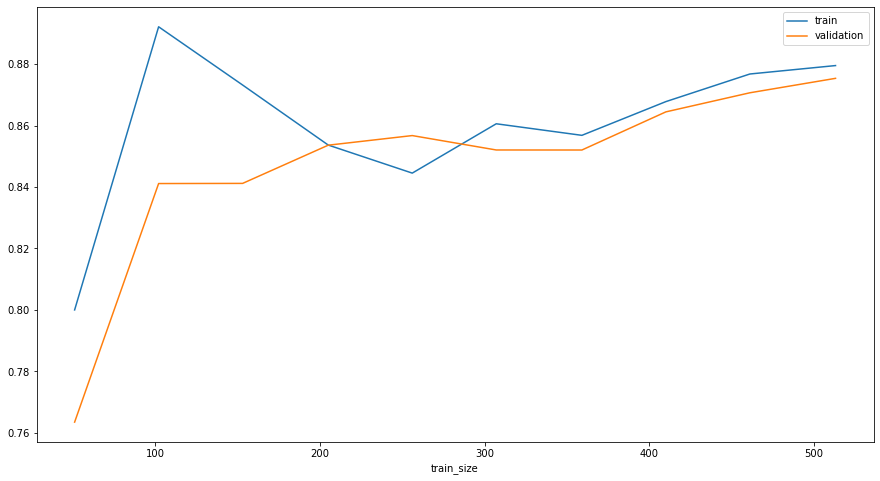

In [55]:
evaluation(model_valid, X_train, y_train, X_test, y_test)

### OPTIMISATION PARAMETRES MODEL SVC

In [78]:
param_grid2 = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma' : [0.1, 1, 10, 100]

}

grid2 = GridSearchCV(SVC(), param_grid2, cv=5)

In [79]:
grid2.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [0.1, 1, 10, 100]})

In [80]:
# Le meilleur score 
grid2.best_score_

0.8738250968992247

In [81]:
# Meilleur paramètre
grid2.best_params_

{'C': 1, 'gamma': 0.1}

In [82]:
# Souvegarde du modèle
modelopt_SVC=grid2.best_estimator_

SVC
Score à l'entrainement : 0.897196261682243
Score au test : 0.8804347826086957
[[ 97  23]
 [ 10 146]]
              precision    recall  f1-score   support

           0       0.91      0.81      0.85       120
           1       0.86      0.94      0.90       156

    accuracy                           0.88       276
   macro avg       0.89      0.87      0.88       276
weighted avg       0.88      0.88      0.88       276



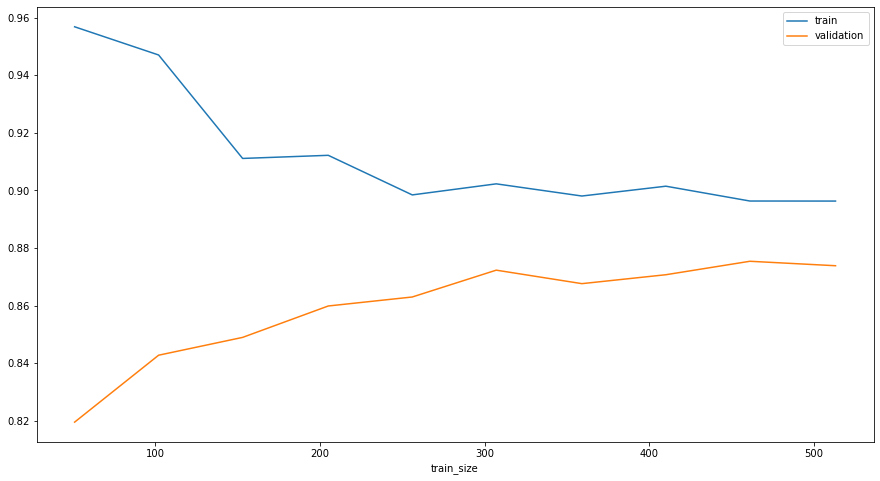

In [83]:
evaluation(modelopt_SVC, X_train, y_train, X_test, y_test)

- Le modèle SVC s'améliore et obtient un score de 88% et une précision qui a aussi augmentée de 4%.